<a href="https://polly.elucidata.io/manage/workspaces?action=open_polly_notebook&amp;source=github&amp;path=ElucidataInc%2Fpolly-python%2Fblob%2Fmain%2FAnalyse%2Fconsumption_starter_notebooks%2Fsinglecell_polly_python.ipynb&amp;kernel=elucidata%2FSingle-cell+Downstream&amp;machine=medium" target="_parent"><img alt="Open in Polly" src="https://elucidatainc.github.io/PublicAssets/open_polly.svg"/></a>


# Welcome to Pollyglot Notebook for analysis of single cell data

This notebook allows you to get started with analysis of single cell data type on Polly

<blockquote>When you first open the notebook, please run the code cells below.</blockquote>

For more details on how to use Notebooks on Polly, please visit [Polly Notebooks](https://docs.elucidata.io/Scaling%20compute/Polly%20Notebooks.html).

For more details on API access to your OmixAtlas, please visit [Accessing OmixAtlas using polly-python through Polly Notebooks](https://docs.elucidata.io/OmixAtlas/Polly%20Python.html).

In [3]:
# please do not modify
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Install Polly Python

In [4]:
!sudo pip3 install polly-python # to search and download selected dataset

Looking in indexes: https://pypi.org/simple, http://54.245.179.143:80/
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
restartkernel() #Pause for a few seconds before the kernel is refreshed

In [1]:
# please do not modify
from IPython.display import HTML
HTML('''<script type="text/javascript"> Jupyter.notebook.kernel.execute("url = '" + window.location + "'", {}, {}); </script>''')

## Fetch OmixAtlas ID and Dataset ID

- **OmixAtlas ID**: Unique target repository identifier which is required for downloading datasets using **polly-python** 
- **Dataset ID**: Unique identifier for datasets on Polly which is required for downloading datasets using **polly-python** 

In [22]:
repo_id = 17
repo_name = 'sc_data_lake'
dataset_id = 'GSE48865_GPL11154'
file_name = dataset_id+'.h5ad'

## Get Authentication Token

### Query metadata in Liver OmixAtlas

All data in Liver OmixAtlas are structured and and stored in indexes that can be queries through polly python  

Metadata fields are curated and tagged with ontologies, which simplifies finding relevant datasets  

To filter and search the metadata in any of the indexes in Liver OmixAtlas, the following function can be used:  


                                **query_metadata (** *query written in SQL* **)**
The SQL queries have the following syntax:

                        **SELECT** *field names* **FROM** *index_name* **WHERE** *conditions*

For a list of curated fields, indices and conditions available for querying, please visit [Data Schema](https://docs.elucidata.io/OmixAtlas/Data%20Schema.html)

In [6]:
#Import packages
from polly.omixatlas import OmixAtlas
import os
import pandas as pd
from json import dumps

In [7]:
AUTH_TOKEN=(os.environ['POLLY_REFRESH_TOKEN']) # Obtain authentication tokens
omixatlas = OmixAtlas(AUTH_TOKEN)

In [23]:
# Querying dataset
query=f"SELECT * FROM {repo_name}.datasets WHERE dataset_id = '{dataset_id}'"
results=omixatlas.query_metadata(query)
results

Query execution succeeded
Fetched 1 rows


,dataset_source,dataset_id,geo_series_id,geo_platform_id,pubmed_ids,title,summary,organism,tissue,disease,submission_date,species,description,kw_data_type,publication,curation_version,kw_cell_type,kw_cell_line,kw_drug,kw_gene,total_num_samples,total_num_cells,platform,kw_repo,kw_package,kw_key,kw_bucket,kw_filetype,kw_region,kw_location,kw_timestamp
0,GEO,GSE48865_GPL11154,GSE48865,GPL11154,[25135958],Whole transcriptome sequencing in 274 glioma p...,We detected fusion genes in 274 fresh surgical...,Homo sapiens,[None],[Glioblastoma],Jul 15 2013,Human,Whole transcriptome sequencing in 274 glioma p...,Single cell,https://pubmed.ncbi.nlm.nih.gov/25135958/,g3,[neoplastic cell],[None],[temozolomide],"[FGFR3, TP53, EGFR, PIK3CA, IDH1, RB1, SLC26A1...",269,269,sc-RNASeq,sc_data_lake,sc_data_lake/data,sc_data_lake/data/GSE48865_GPL11154/adata.h5ad,discover-prod-datalake-v1,h5ad,us-west-2,https://discover-prod-datalake-v1.s3-us-west-2...,1645442148481


## Download and load the h5ad file
Single cell dataset is stored in h5ad file. A HEAD file (.H5AD) file that provides a scalable way of keeping track of data together with learned annotations. Please read more about h5ad file format [here](https://anndata.readthedocs.io/en/latest/). We store single cell data in h5ad format. An h5ad file can be read in R and python using [scanpy](https://scanpy.readthedocs.io/en/stable/) (both for python and R).

In [26]:
data = omixatlas.download_data(repo_id, dataset_id)
url = data.get('data').get('attributes').get('download_url')
status = os.system(f"wget -O '{file_name}' '{url}'")
if status == 0:
    print("Downloaded data successfully")
else:
    raise Exception("Download not successful")

Downloaded data successfully


In [27]:
# loading the file
import scanpy as sc
data = sc.read_h5ad(file_name) 
data

AnnData object with n_obs × n_vars = 269 × 33563
    obs: 'sample', 'title', 'source', 'characteristics', 'characteristics_id', 'source_id', 'umi_counts', 'umi_counts_log', 'gene_counts', 'gene_counts_log', 'percent_mito', 'clusters', 'kw_curated_cell_line', 'kw_curated_disease', 'kw_curated_drug', 'kw_curated_tissue', 'kw_cell_type_singleR', 'cell_type_singleR'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'geneexp_cell_Astrocyte', 'geneexp_cell_Monocytes', 'geneexp_cell_NA', 'geneexp_cell_Neurons', 'geneexp_cell_Smooth_muscle_cells', 'geneexp_cell_Tissue_stem_cells', 'geneexp_characteristics_0', 'geneexp_characteristics_1', 'geneexp_characteristics_2', 'geneexp_characteristics_3', 'geneexp_characteristics_4', 'geneexp_characteristics_5', 'geneexp_characteristics_6', 'geneexp_characteristics_7', 'geneexp_characteristics_8', 'geneexp_characteristics_9', 'geneexp_characteristics_10', 'geneexp_characteristics_11', 'geneexp_characteristics_12', 'geneex

In [28]:
data.obs.head()

,sample,title,source,characteristics,characteristics_id,source_id,umi_counts,umi_counts_log,gene_counts,gene_counts_log,percent_mito,clusters,kw_curated_cell_line,kw_curated_disease,kw_curated_drug,kw_curated_tissue,kw_cell_type_singleR,cell_type_singleR
index,,,,,,,,,,,,,,,,,,
GSM1186071,GSM1186071_GPL11154,CGGA_1301,Tumor cells,history: primary Glioblastomas,6,0,15417192.0,7.188005,22490,4.352009,0.079973,0,none,Normal,none,none,Astrocyte,Astrocyte
GSM1185884,GSM1185884_GPL11154,CGGA_309,Tumor cells,history: recurrent Glioblastomas,7,0,21386472.0,7.330139,22009,4.342620,0.083442,1,none,Normal,none,none,Astrocyte,Astrocyte
GSM1185946,GSM1185946_GPL11154,CGGA_675,Tumor cells,history: oligodendroastrocytomas,4,0,13925575.0,7.143813,20244,4.306318,0.070923,0,none,Normal,none,none,Astrocyte,Astrocyte
GSM1186094,GSM1186094_GPL11154,CGGA_1046-1,Tumor cells,history: astrocytomas,3,0,25107920.0,7.399811,21213,4.326623,0.141919,0,none,Normal,none,none,Astrocyte,Astrocyte
GSM1186062,GSM1186062_GPL11154,CGGA_1251,Tumor cells,history: recurrent anaplastic oligodendroastro...,9,0,28039166.0,7.447765,21127,4.324858,0.048691,2,none,Normal,none,none,Astrocyte,Astrocyte


In [29]:
data.var.head()

,n_cells,highly_variable,means,dispersions,dispersions_norm,geneexp_cell_Astrocyte,geneexp_cell_Monocytes,geneexp_cell_NA,geneexp_cell_Neurons,geneexp_cell_Smooth_muscle_cells,geneexp_cell_Tissue_stem_cells,geneexp_characteristics_0,geneexp_characteristics_1,geneexp_characteristics_2,geneexp_characteristics_3,geneexp_characteristics_4,geneexp_characteristics_5,geneexp_characteristics_6,geneexp_characteristics_7,geneexp_characteristics_8,geneexp_characteristics_9,geneexp_characteristics_10,geneexp_characteristics_11,geneexp_characteristics_12,geneexp_characteristics_13,geneexp_cluster_0,geneexp_cluster_1,geneexp_cluster_2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1BG,269,True,0.026738,-4.610865,0.769156,0.025566,0.045505,0.027548,0.050026,0.028029,0.032965,0.025563,0.029117,0.022863,0.022629,0.018805,0.018991,0.031174,0.040016,0.030339,0.028664,0.024401,0.027273,0.025620,0.026382,0.021913,0.032345,0.029046
A1CF,237,False,0.001879,-5.084489,0.511688,0.001759,0.026368,0.001298,0.001434,0.005126,0.002366,0.002453,0.001658,0.000925,0.001473,0.001398,0.002368,0.001904,0.001845,0.001950,0.003039,0.000679,0.004100,0.001562,0.001706,0.001667,0.002120,0.002050
A2M,269,True,0.950197,-1.043916,0.827976,0.950120,0.949194,1.237023,1.245987,1.410898,1.306662,1.231734,1.032942,0.718270,0.867290,0.764329,0.696720,1.124280,1.150118,1.093675,0.851533,1.153445,1.011431,0.825748,1.019448,0.784452,1.182231,0.794946
A2ML1,268,True,0.034989,-3.173216,1.550681,0.037910,0.085379,0.022361,0.012087,0.020224,0.019258,0.063653,0.047431,0.024954,0.053875,0.040417,0.035163,0.027261,0.034548,0.022213,0.028353,0.016874,0.033092,0.023461,0.017016,0.043635,0.029489,0.015654
A2MP1,269,False,0.010812,-2.862723,1.719469,0.011632,0.014468,0.013643,0.004976,0.014923,0.005971,0.008458,0.012632,0.008577,0.008507,0.011167,0.012195,0.007736,0.031866,0.010449,0.011385,0.016666,0.009699,0.008540,0.006557,0.010755,0.012484,0.005869


## QC plot
### 'gene_counts' - number of unique genes detected in each cell.
### 'umi_counts' - total number of molecules detected within a cell (correlates strongly with unique genes)
### 'percent_mito' - percentage of reads that map to the mitochondrial genome

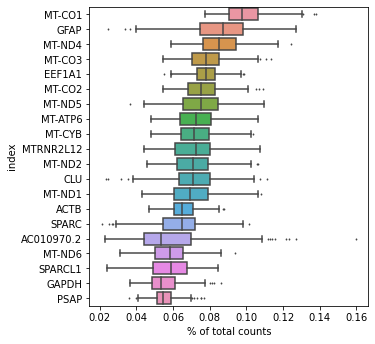

In [30]:
sc.pl.highest_expr_genes(data, n_top=20)

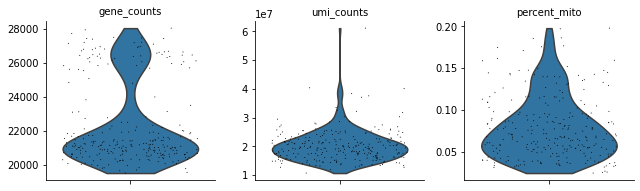

In [31]:
sc.pl.violin(data, ['gene_counts', 'umi_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

## Samples and Clusters Distribution

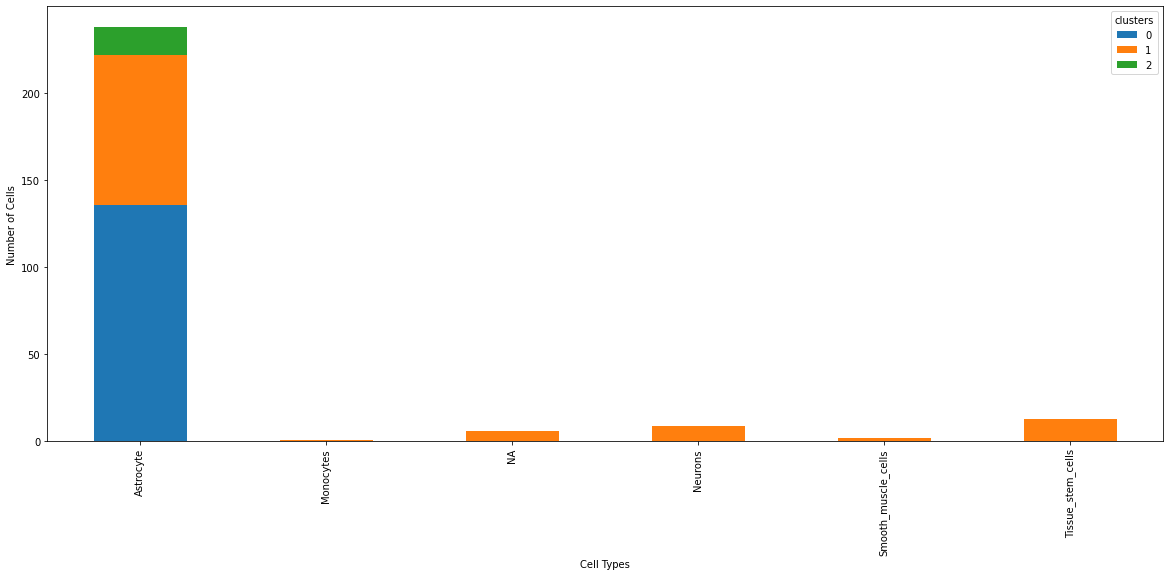

In [32]:
if "kw_cell_type_singleR" in data.obs.columns:
    
    sam_clus_dis = pd.DataFrame(data.obs.groupby(['kw_cell_type_singleR', 'clusters'])["clusters"].count())
    sam_clus_dis.rename(columns = {'clusters': 'counts'}, inplace = True)
    sam_clus_dis = sam_clus_dis.reset_index()
    sam_clus_dis = data.obs.groupby(['kw_cell_type_singleR', 'clusters'])["clusters"].count().unstack('clusters')
    ax = sam_clus_dis.plot(kind='bar', stacked=True, xlabel="Cell Types", ylabel='Number of Cells', figsize=(20, 8))
    
elif "clusters" in data.obs.columns:
    clus_dis = pd.DataFrame(data.obs.clusters.value_counts())
    ax = clus_dis.plot(kind='bar', stacked=True, xlabel='Clusters', ylabel='Number of Cells', figsize=(20, 8)) 


## tSNE plot

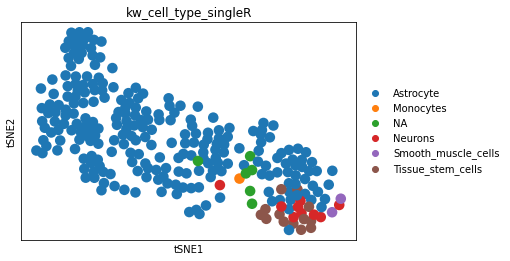

In [33]:
if "X_tsne" in data.obsm:
    if "kw_cell_type_singleR" in data.obs.columns:
        sc.pl.tsne(data, color = 'kw_cell_type_singleR')
    else:
        sc.pl.tsne(data, color = 'clusters')
else:
    print("tSNE Plot is not available")

## UMAP plot

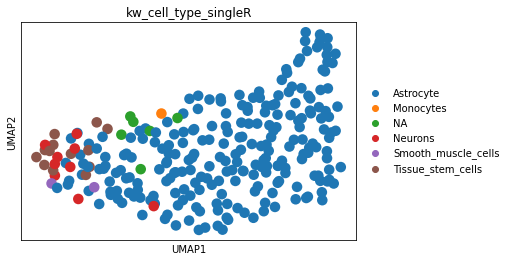

In [34]:
if "X_umap" in data.obsm:
    if "kw_cell_type_singleR" in data.obs.columns:
        sc.pl.umap(data, color = 'kw_cell_type_singleR')
    else:
        sc.pl.umap(data, color = 'clusters')
else:
    print("Umap Plot is not available")